# SEASONAL FORECASTS: hit-score

## Use case: a national hydro-met services informing decisions in agricultural or energy applications

# Quality assessment questions
What are the hit rates for above/below normal anomalies? 
Is this an adequate measure of forecast quality

  

# Introduction

Seasonal forecasts are not deterministic: they are not expected to bring quantitative information on the value of climate parameters with an attached error bar.

Instead, seasonal forecasts are probabilistic: they provide information on how the probability density function (PDF) of climate parameters are expected to change during the coming months compared to climatology, provided the current state of the climate system.

A key issue concerning the usability of seasonal forecast is that end users do not always have a mean to value the knowledge about the PDF of climate variables. Many practical decisions, for which seasonal forecast might be beneficial require some form of dichtomic choice, for example:
 - Do I have to plan for anticipated harvest?
 - Do I have to choose the long-cycle or short-cycle maize variety for the coming season?
 - Will the coming season allow a reduced number of treatments? 

Indeed, the WMO [Guidance on Verification of Operational Seasonal Climate Forecasts](https://library.wmo.int/records/item/56227-guidance-on-verification-of-operational-seasonal-climate-forecasts) highlights how the use of generalized methodologies for the assessment of seasonal forecasts sometimes represent limited attraction for new users. Therefore, the [Guidance](https://library.wmo.int/records/item/56227-guidance-on-verification-of-operational-seasonal-climate-forecasts) recommends a range of methodologies of increasing complexity, including very simple ones, which are particularly useful for introducing the potential value of seasonal forecasts to non-specialists.

This notebook focuses on the hit-score, a simple yet fundamental building block for more articulated and comprehensive quality indicators such as the ROC skill score.
 

## **METHOD**

The computation of the hit-score is straightforward: the monthly climatology of the selected ECV (e.g. temperature) is first divided in terciles (below normal, normal, above normal). Then, the hit-score is computed by counting the number of events when the most populated tercile derived from the distribution of the seasonal forecasts corresponds to the observed tercile of the target month. 

In this notebook, seasonal forecasts are assessed against ERA5.

Assuming temperature T as the variable of interest, the computation of hit-rates entails the follotwing steps

### *Process ERA5*

1.	Compute the mean monthly temperature from the reanalysis over a few selected SREX regions.

2. Remove the the linear trend to avoid artificially inflated hit-scores cause by long-term tendencies. This step is critical in the the analysis of hit-scores for temperature.

3.	For each month, and for each region, compute the values associated to the 33-th and 66-th percentile of the corresponding monthly distribution

4.	Convert the series of mean monthly temperature anomalies over each region into the corresponding terciles, using the following conversion table:  

   - -1 = below, values below the 33-th percentile normal
   - 0 , values between the 33-th and the 66-th percentile
   - 1 = above normale, values above the 33-th percentilevnormal

### *Process seasonal forecasts*
5.	Apply step 1. for each seasonal forecasting system. In this case there is a different temperature anomaly for each originatng centre, ensemble member, starting time and valid time for the forecast.

6. Apply step 2. to remove linear trends.

7. Apply step 3. to  obtain the position of the terciles for each originating centre and for each starting time and valid time. In this case, the underlying distribution for the computation of the terciles includes all years in the hindcast as well as all ensemble members. The 33-th and 66-th percentiles depend on the leadtime, i.e. the difference between valid time and starting time, so that the analysis accounts for potential model dirfts.

8. Apply step 4. to convert temperature anomalies into the corresponding terciles for all regions, for all time months and valid time, and for each member of the ensemble forecast.

9. The most likely tercile in the forecast is derived by computing the mode of the terciles step 8. over all ensamble. The most likely terciles  is an array whose dimensions are the originationg centres, the region, the starting time and the valid time.

### *Compute hit-score*
10. The hit-score is computed by counting the number of years in which the most likely tercile in the seasonal forecast matches the tercile derived from the reanalysis, and then  viding by the number of forecasts.  Hit-scores depend on the starting month andh on the valid month for each selected SREX regions

### *Visualization*
11. The hit-score for each selected area are visualized as a function of the starting month and on the valid month.of the forecast.

## ANALYSIS

### Import packages

The package `regionmask` is used to mask out the SREX regions selected for the analysis.

In [1]:
import tempfile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import regionmask
import scipy.stats
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download

plt.style.use("seaborn-v0_8-notebook")

## Define parameters

The analysis of hit-scores is conducted over 5 different variables  for the 8 originating centres. The SREX regions selected for the analysis are.

- EAF: Eastern Africa
- ENA: Eastern North America
- MED: Southern Europe/Mediterranean
- NEB: North-eastern Brazil
- SAS: Southern Asia
- SEA: South-Eastern Asia
- WNA: Western North America
- WSA: Western Coast of South America

In [2]:
# Time
year_start_hindcast = 1993
year_stop_hindcast = 2016

# Detrend timeseries
detrend = True
assert isinstance(detrend, bool)

# Variable
variables = [
    "2m_temperature",
    "total_precipitation",
    "surface_solar_radiation_downwards",
    "10m_wind_speed",
    "2m_dewpoint_temperature",
]

# Define centres with missing variables
missing_variables = {"eccc": ["2m_dewpoint_temperature"]}

# Centres
centres = {
    "cmcc": {"system": "35"},
    "dwd": {"system": "21"},
    "eccc": {"system": "3"},
    "ecmwf": {"system": "51"},
    "jma": {"system": "3"},
    "meteo_france": {"system": "8"},
    "ncep": {"system": "2"},
    "ukmo": {"system": "601"},
}
assert all("system" in v for v in centres.values())
assert set(centres) <= {
    "cmcc",
    "dwd",
    "eccc",
    "ecmwf",
    "jma",
    "meteo_france",
    "ncep",
    "ukmo",
}

# Regions
regions = [
    "EAF",
    "ENA",
    "MED",
    "NEB",
    "SAS",
    "SEA",
    "WNA",
    "WSA",
]
assert set(regions) <= set(regionmask.defined_regions.srex.abbrevs)

## Plot selected regions

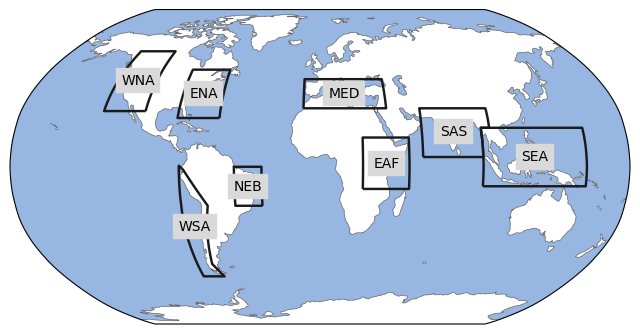

In [3]:
ax = regionmask.defined_regions.srex[regions].plot(
    projection=ccrs.Robinson(),
    label="abbrev",
    add_ocean=True,
)
ax.set_global()

### Define requests

In [4]:
chunks = {"year": 1, "variable": 1}
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "year": [str(year) for year in range(year_start_hindcast, year_stop_hindcast + 1)],
}

collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"
request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
}

collection_id_seasonal = "seasonal-monthly-single-levels"
request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "leadtime_month": list(map(str, range(1, 7))),
    "month": [f"{month:02d}" for month in range(1, 13)],
    "grid": "1/1",
}

### Functions to cache

In [5]:
def mode(*args, axis=None, **kwargs):
    return scipy.stats.mode(*args, axis=axis, **kwargs).mode


def reindex_seasonal_forecast(ds):
    # Stack starting_time and leading_month
    ds = ds.rename(forecast_reference_time="starting_time")
    ds = ds.stack(
        time=("starting_time", "leadtime_month"),
        create_index=False,
    )

    # Shift valid_time
    ds = ds.set_index(time="starting_time")
    valid_time = ds.indexes["time"]
    for shift in set(ds["leadtime_month"].values):
        shifted = ds.indexes["time"].shift(shift - 1, "MS")
        valid_time = valid_time.where(ds["leadtime_month"] != shift, shifted)

    # Reindex: valid_time and starting_month
    coords = {
        "valid_time": ("time", valid_time),
        "starting_month": ("time", ds["time"].dt.month.data),
    }
    ds = ds.assign_coords(coords)
    ds = ds.set_index({"time": tuple(coords)}).unstack("time")
    return ds


def compute_tercile_occupation(ds, region, detrend):
    # Mask region
    mask = regionmask.defined_regions.srex.mask(ds)
    index = regionmask.defined_regions.srex.map_keys(region)
    ds = ds.where((mask == index).compute(), drop=True)
    ds = ds.expand_dims(region=[region])

    # Spatial mean
    ds = diagnostics.spatial_weighted_mean(ds)

    if "leadtime_month" in ds.dims:
        ds = reindex_seasonal_forecast(ds)
    else:
        ds = ds.rename(forecast_reference_time="valid_time")

    if detrend:
        # Detrend timeseries
        time = ds["valid_time"]
        fit = ds.polyfit(time.name, deg=1, w=time.dt.days_in_month)
        fit = fit.rename(
            {var: var.replace("_polyfit_coefficients", "") for var in fit.data_vars}
        )
        ds -= xr.polyval(time, fit)

    # Compute anomaly
    climatology = diagnostics.time_weighted_mean(ds, time_name="valid_time")
    climatology = climatology.mean(set(climatology.dims) & {"realization"})
    ds -= climatology

    # Reindex using valid year/month month
    time = ds["valid_time"]
    coords = {
        "valid_year": (time.name, time.dt.year.data),
        "valid_month": (time.name, time.dt.month.data),
    }
    ds = ds.assign_coords(coords)
    ds = ds.set_index({time.name: tuple(coords)}).unstack(time.name)

    # Get quantiles
    quantiles = ds.chunk(valid_year=-1).quantile([1 / 3, 2 / 3], "valid_year")
    low = quantiles.sel(quantile=1 / 3)
    high = quantiles.sel(quantile=2 / 3)
    mask = xr.full_like(ds, None)
    mask = xr.where(ds < low, -1, mask)
    mask = xr.where((ds >= low) & (ds <= high), 0, mask)
    mask = xr.where(ds > high, 1, mask)

    if "realization" in mask.dims:
        # Get mode
        mask = mask.reduce(mode, dim="realization")

    return mask.reset_coords(drop=True)

# Plot functions

In [6]:
def plot_tercile_occupations(da, **kwargs):
    cmap = kwargs.pop("cmap", "RdYlBu_r")
    kwargs["cmap"] = plt.get_cmap(cmap, 3)
    cbar_kwargs = {"ticks": [-2 / 3, 0, 2 / 3]}

    plot_obj = da.plot(cbar_kwargs=cbar_kwargs, **kwargs)

    cbar = (
        plot_obj.cbar
        if isinstance(plot_obj, xr.plot.facetgrid.FacetGrid)
        else plot_obj.colorbar
    )
    cbar.ax.set_yticklabels(["Low", "Medium", "High"])
    return plot_obj

# Download and transform ERA5

In [7]:
# Get the reanalysis data
datasets = []
for region in regions:
    dataarrays = []
    for variable in variables:
        print(f"{region=} {variable=}")
        ds = download.download_and_transform(
            collection_id_reanalysis,
            request_reanalysis | {"variable": variable},
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_tercile_occupation,
            transform_func_kwargs={"region": region, "detrend": detrend},
        )
        (da,) = ds.data_vars.values()
        dataarrays.append(da.rename(variable))
    ds = xr.merge(dataarrays)
    datasets.append(ds)
ds_reanalysis = xr.concat(datasets, "region")
del datasets

datasets = []
for region in regions:
    dataarrays = []
    for variable in variables:
        print(f"{region=} {variable=}")
        ds = download.download_and_transform(
            collection_id_reanalysis,
            request_reanalysis | {"variable": variable},
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_tercile_occupation,
            transform_func_kwargs={"region": region,  "detrend": False},
        )
        (da,) = ds.data_vars.values()
        dataarrays.append(da.rename(variable))
    ds = xr.merge(dataarrays)
    datasets.append(ds)
ds_reanalysis_nodetrend = xr.concat(datasets, "region")
del datasets


region='EAF' variable='2m_temperature'
region='EAF' variable='total_precipitation'
region='EAF' variable='surface_solar_radiation_downwards'
region='EAF' variable='10m_wind_speed'
region='EAF' variable='2m_dewpoint_temperature'
region='ENA' variable='2m_temperature'
region='ENA' variable='total_precipitation'
region='ENA' variable='surface_solar_radiation_downwards'
region='ENA' variable='10m_wind_speed'
region='ENA' variable='2m_dewpoint_temperature'
region='MED' variable='2m_temperature'
region='MED' variable='total_precipitation'
region='MED' variable='surface_solar_radiation_downwards'
region='MED' variable='10m_wind_speed'
region='MED' variable='2m_dewpoint_temperature'
region='NEB' variable='2m_temperature'
region='NEB' variable='total_precipitation'
region='NEB' variable='surface_solar_radiation_downwards'
region='NEB' variable='10m_wind_speed'
region='NEB' variable='2m_dewpoint_temperature'
region='SAS' variable='2m_temperature'
region='SAS' variable='total_precipitation'
regio

## Get data and compute the sample bias

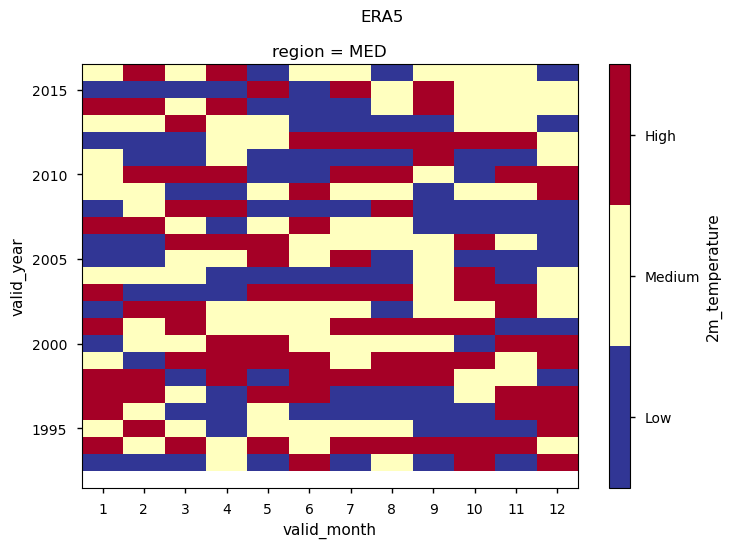

In [8]:
variable = "2m_temperature"
region = "MED"
centre = "cmcc"
assert (variable in variables) and (region in regions) and (centre in centres)

plot_tercile_occupations(
    ds_reanalysis[variable].sel(region=region),
    xticks=range(1, 13),
)
plt.suptitle("ERA5")
plt.show()


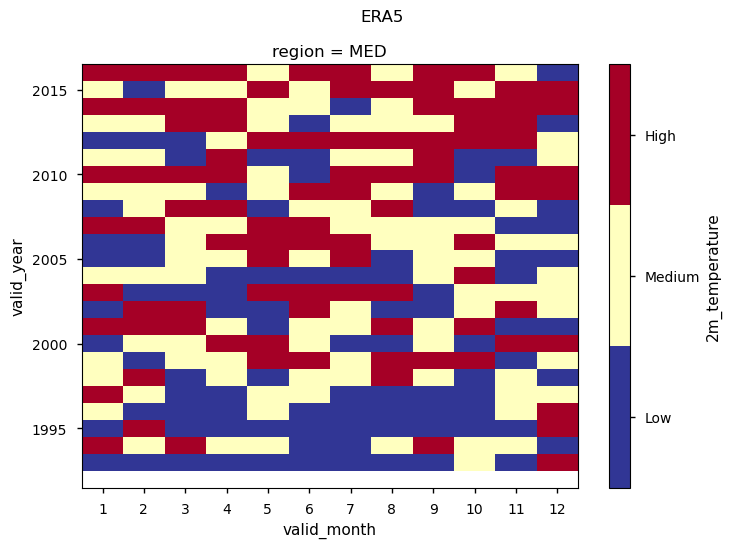

In [11]:
variable = "2m_temperature"
region = "MED"
centre = "cmcc"
assert (variable in variables) and (region in regions) and (centre in centres)

plot_tercile_occupations(
    ds_reanalysis_nodetrend[variable].sel(region=region),
    xticks=range(1, 13),
)
plt.suptitle("ERA5")
plt.show()


# Download and tranform seasonal forecasts

In [10]:
# Get the seasonal forecast data
datasets = []
for centre, request_kwargs in centres.items():
    for region in regions:
        dataarrays = []
        for variable in variables:
            print(f"{centre=} {region=} {variable=}")
            if variable in missing_variables.get(centre, []):
                print("SKIP")
                continue

            with tempfile.TemporaryDirectory() as TMPDIR:
                ds = download.download_and_transform(
                    collection_id_seasonal,
                    request_seasonal
                    | {"originating_centre": centre, "variable": variable}
                    | request_kwargs,
                    chunks=chunks,
                    transform_chunks=False,
                    transform_func=compute_tercile_occupation,
                    transform_func_kwargs={"region": region, "detrend": detrend},
                    backend_kwargs={
                        "time_dims": (
                            "forecastMonth",
                            (
                                "indexing_time"
                                if centre in ["ukmo", "jma", "ncep"]
                                else "time"
                            ),
                        )
                    },
                )
            (da,) = ds.data_vars.values()
            dataarrays.append(da.rename(variable))
        ds = xr.merge(dataarrays)
        datasets.append(ds.expand_dims(centre=[centre]))
ds_seasonal = xr.merge(datasets)
del datasets

centre='cmcc' region='EAF' variable='2m_temperature'
centre='cmcc' region='EAF' variable='total_precipitation'
centre='cmcc' region='EAF' variable='surface_solar_radiation_downwards'
centre='cmcc' region='EAF' variable='10m_wind_speed'
centre='cmcc' region='EAF' variable='2m_dewpoint_temperature'
centre='cmcc' region='ENA' variable='2m_temperature'
centre='cmcc' region='ENA' variable='total_precipitation'
centre='cmcc' region='ENA' variable='surface_solar_radiation_downwards'
centre='cmcc' region='ENA' variable='10m_wind_speed'
centre='cmcc' region='ENA' variable='2m_dewpoint_temperature'
centre='cmcc' region='MED' variable='2m_temperature'
centre='cmcc' region='MED' variable='total_precipitation'
centre='cmcc' region='MED' variable='surface_solar_radiation_downwards'
centre='cmcc' region='MED' variable='10m_wind_speed'
centre='cmcc' region='MED' variable='2m_dewpoint_temperature'
centre='cmcc' region='NEB' variable='2m_temperature'
centre='cmcc' region='NEB' variable='total_precipitat

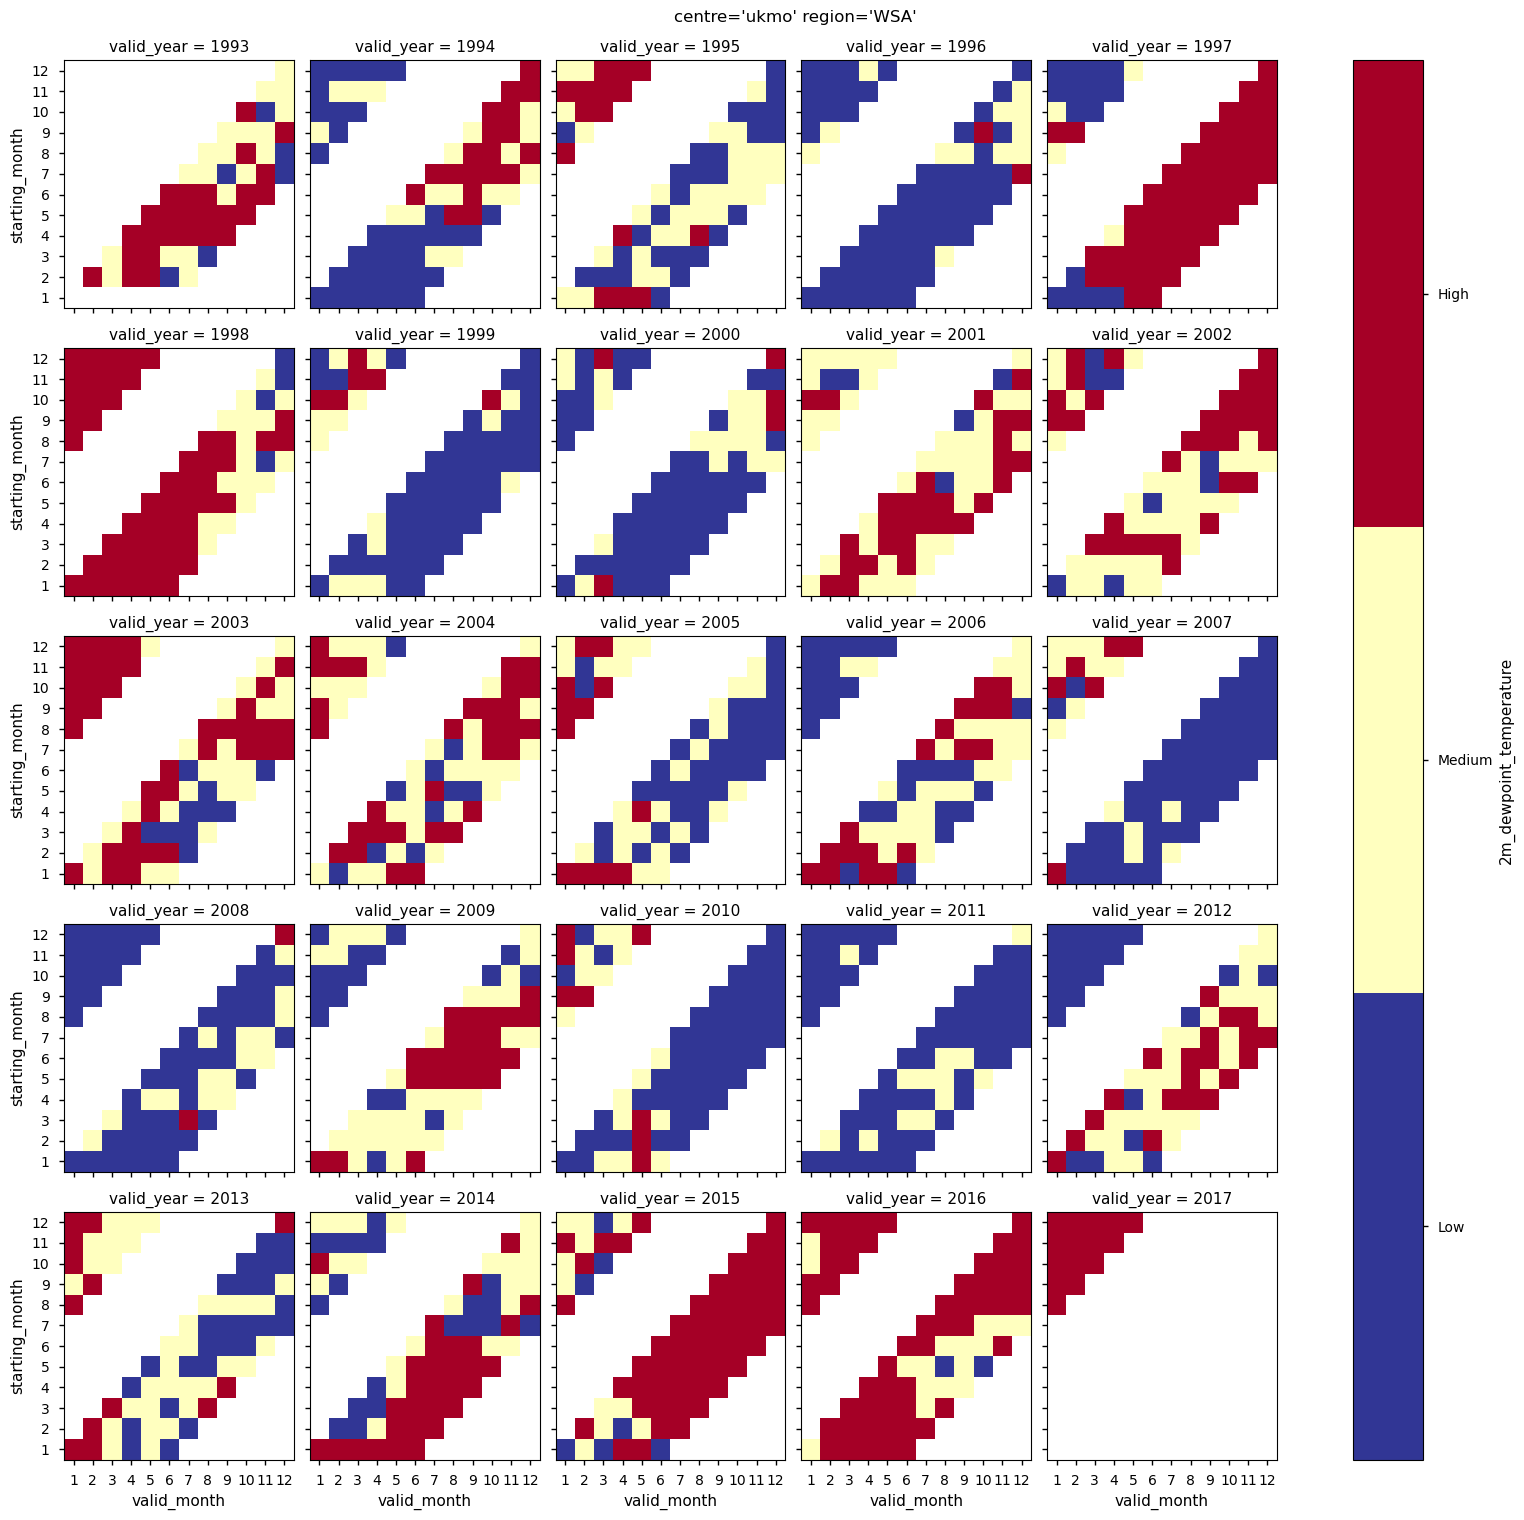

/data/common/miniforge3/envs/wp3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/common/miniforge3/envs/wp3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [11]:

facet = plot_tercile_occupations(
    ds_seasonal[variable].sel(region=region, centre=centre),
    col="valid_year",
    col_wrap=5,
    xticks=range(1, 13),
    yticks=range(1, 13),
)
_ = facet.fig.suptitle(f"{centre=} {region=}", y=1.01)

# Compute hit-score

In [26]:
import numpy as np
masked_ds_seasonal = ds_seasonal.where(ds_seasonal != 0)
hit_rate = (masked_ds_seasonal == ds_reanalysis).sum("valid_year")
hit_rate *= 100 / masked_ds_seasonal.notnull().sum("valid_year")

hit_rate_mask = hit_rate
hit_rate_mask = xr.where(hit_rate < 60, np.nan, hit_rate)

# Plot hit-score

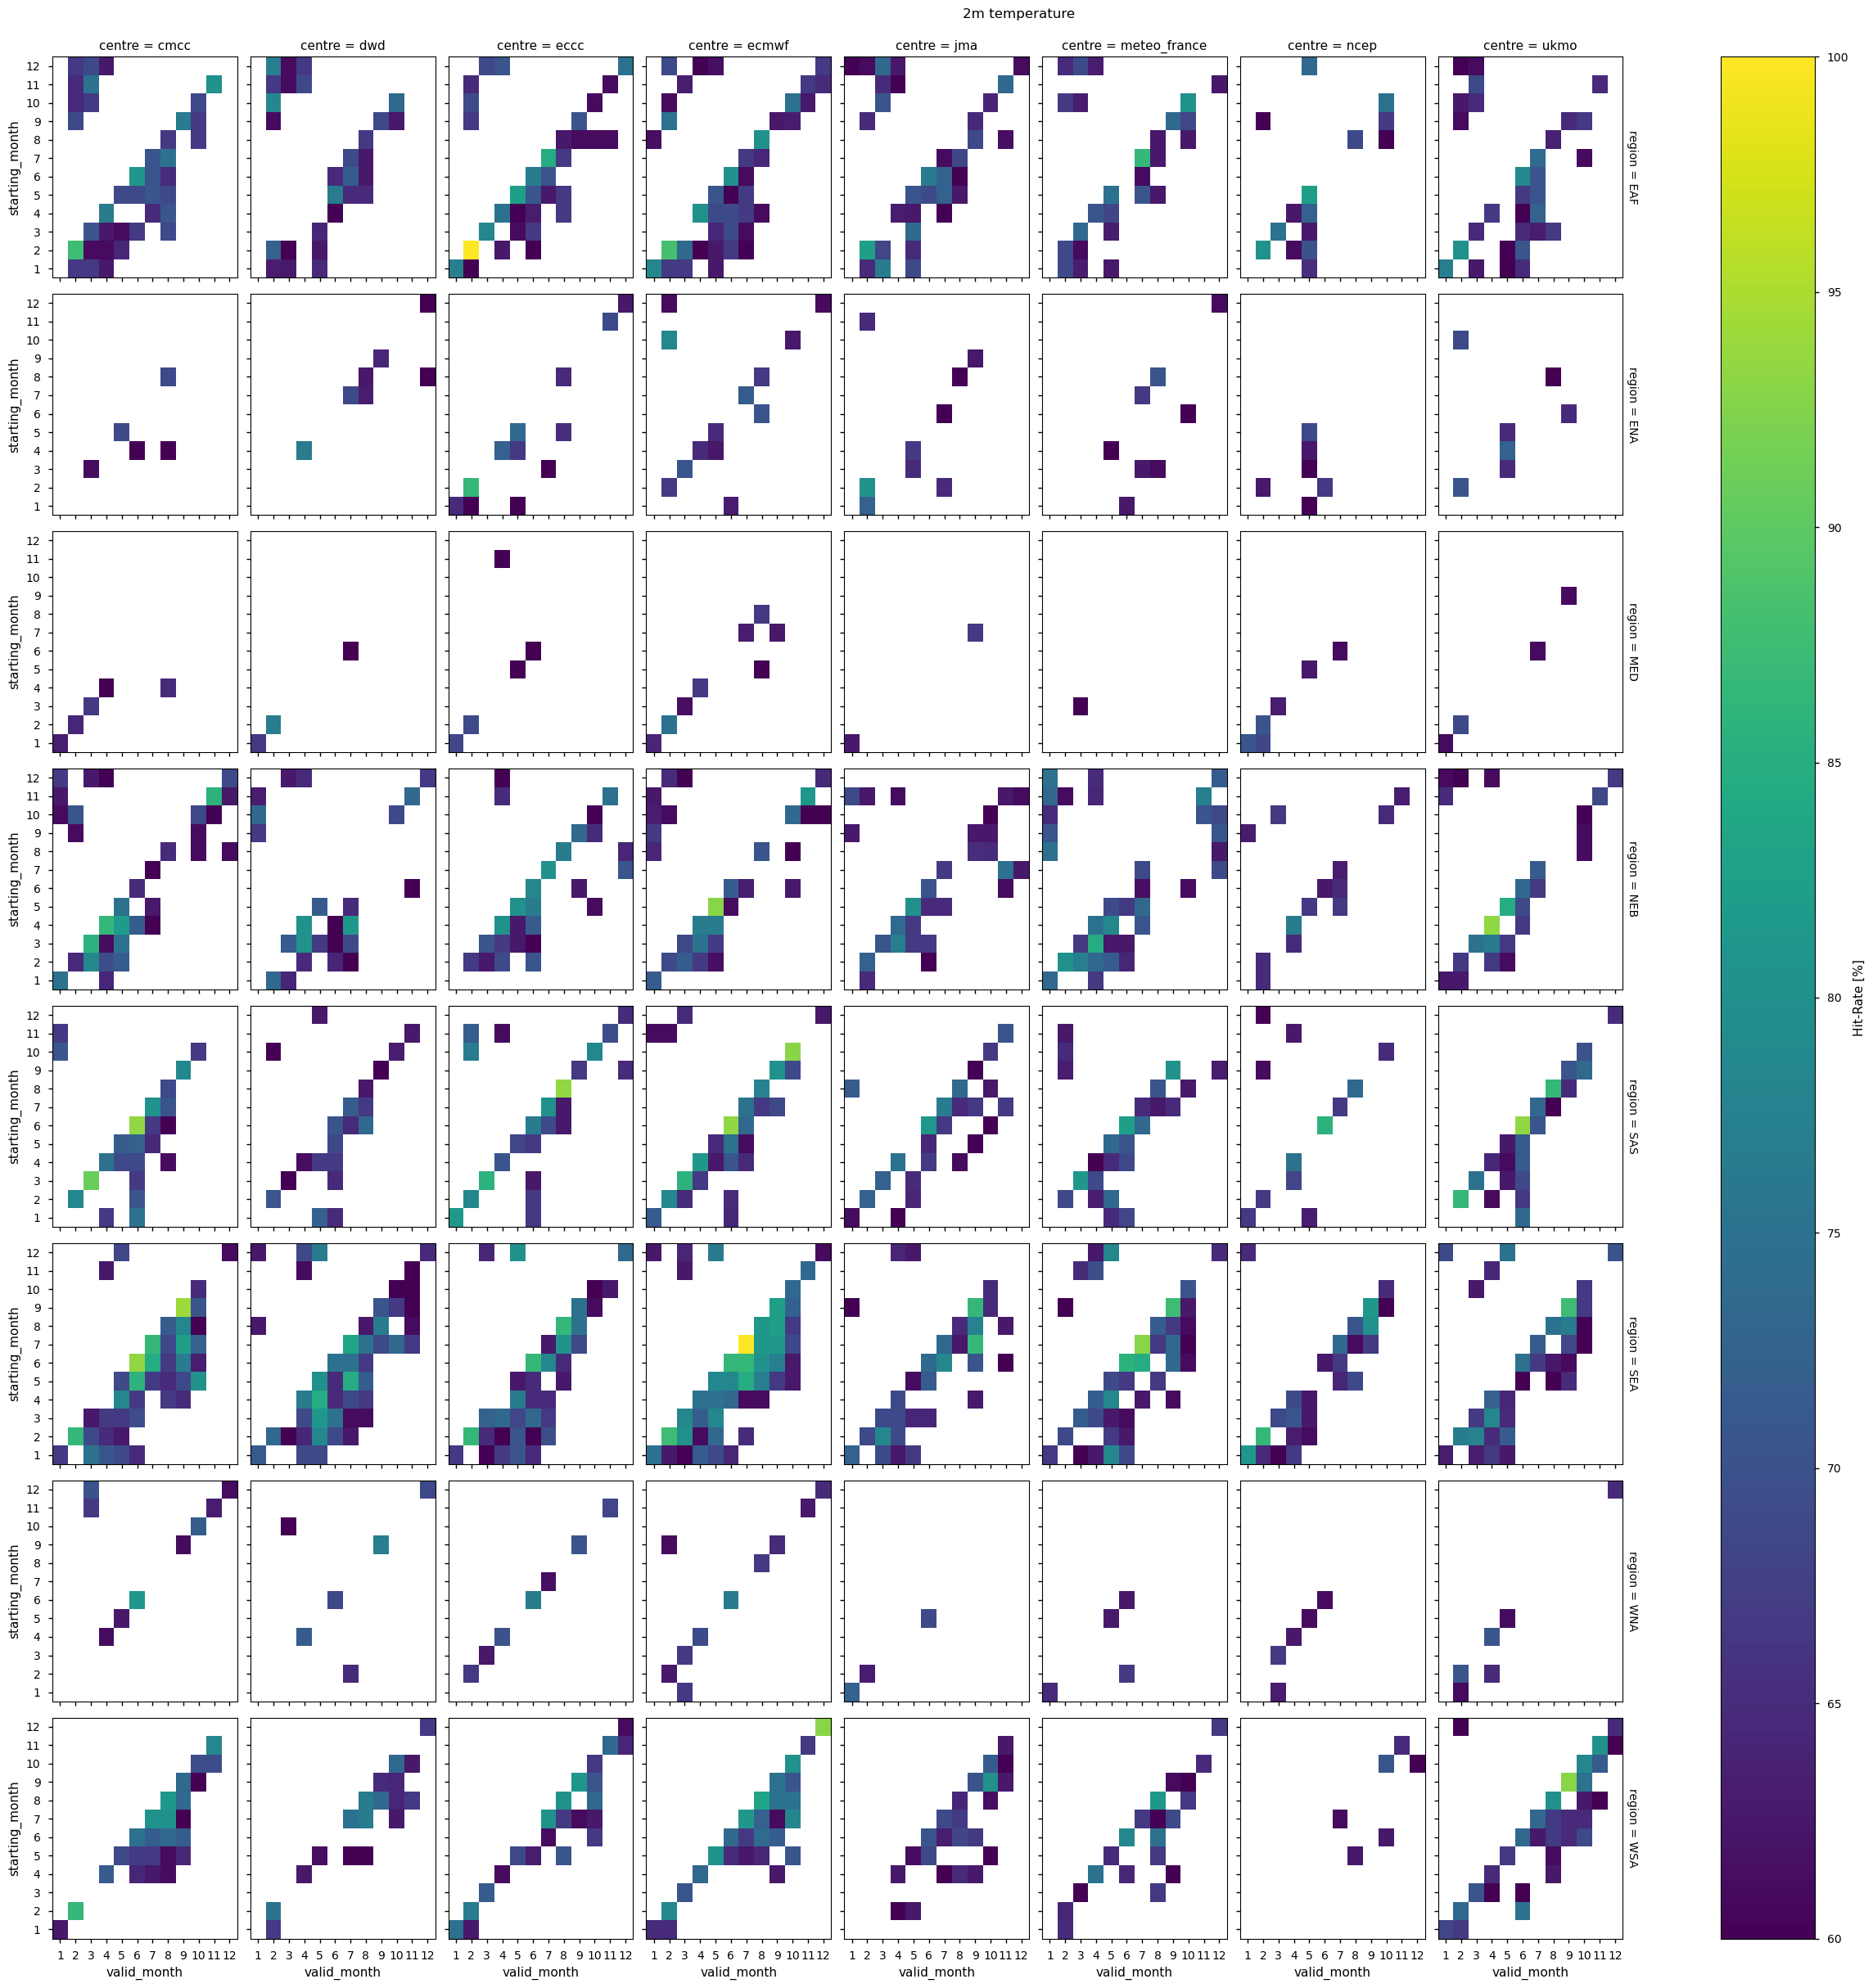

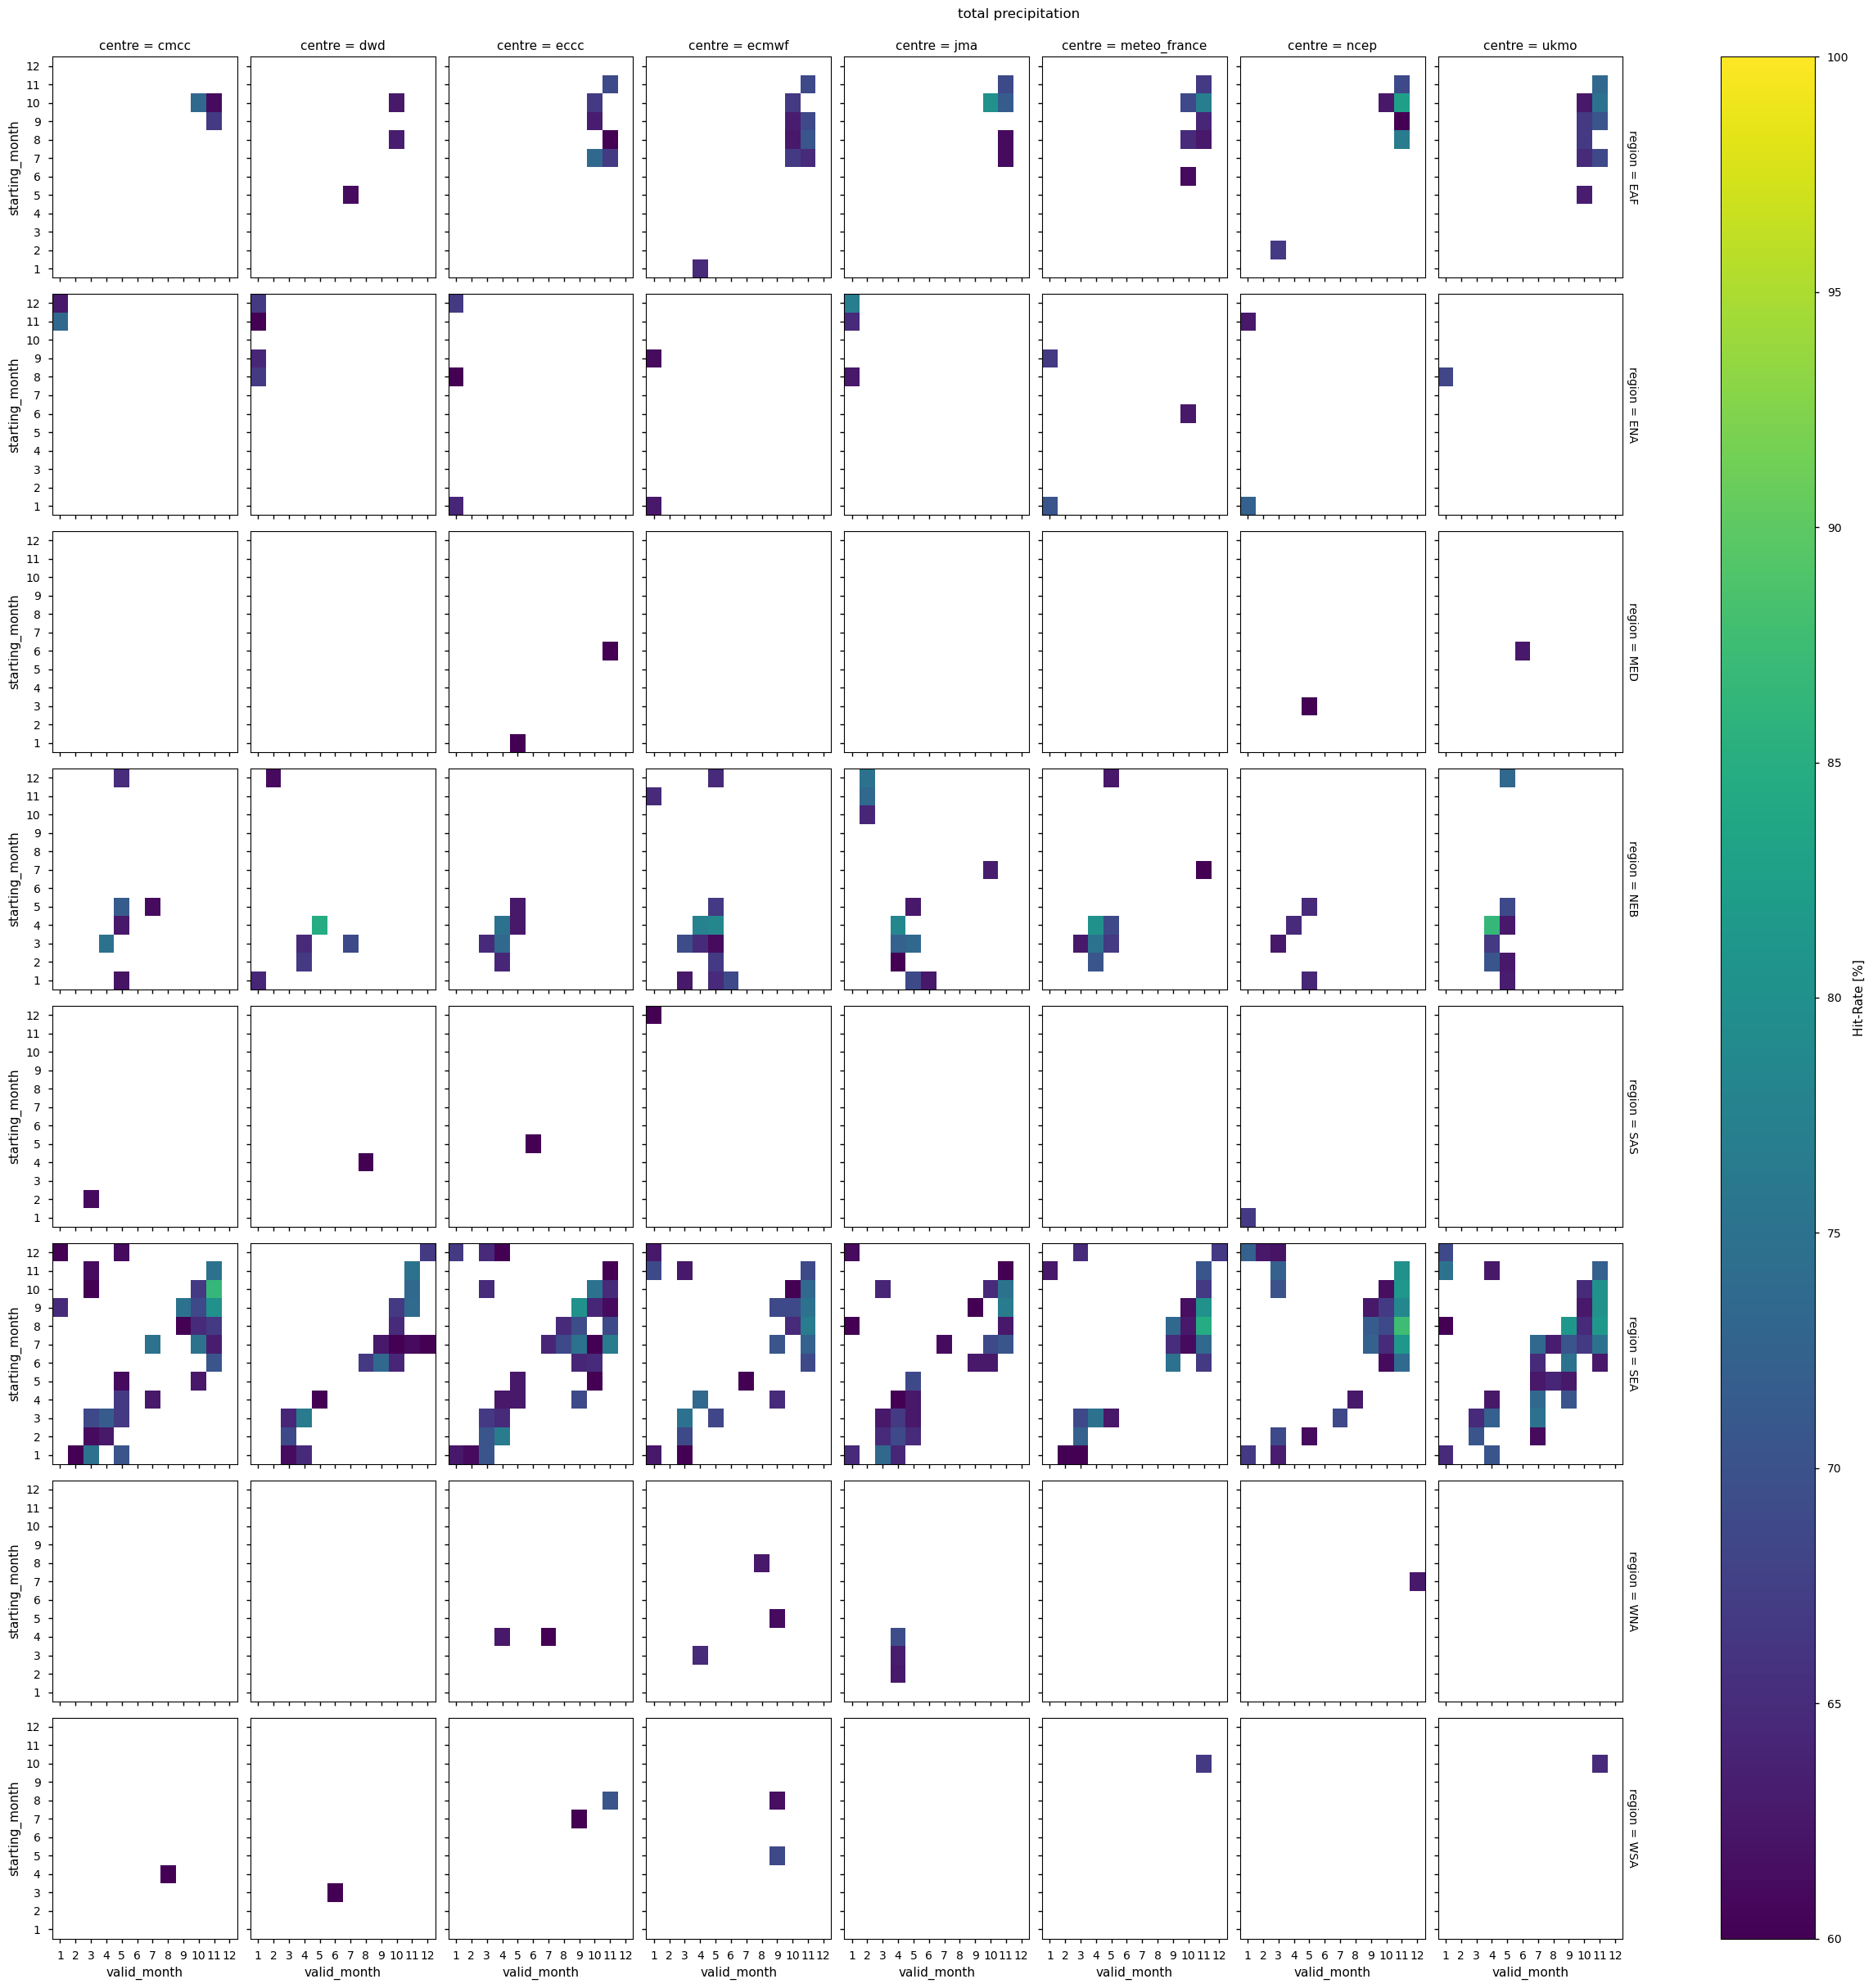

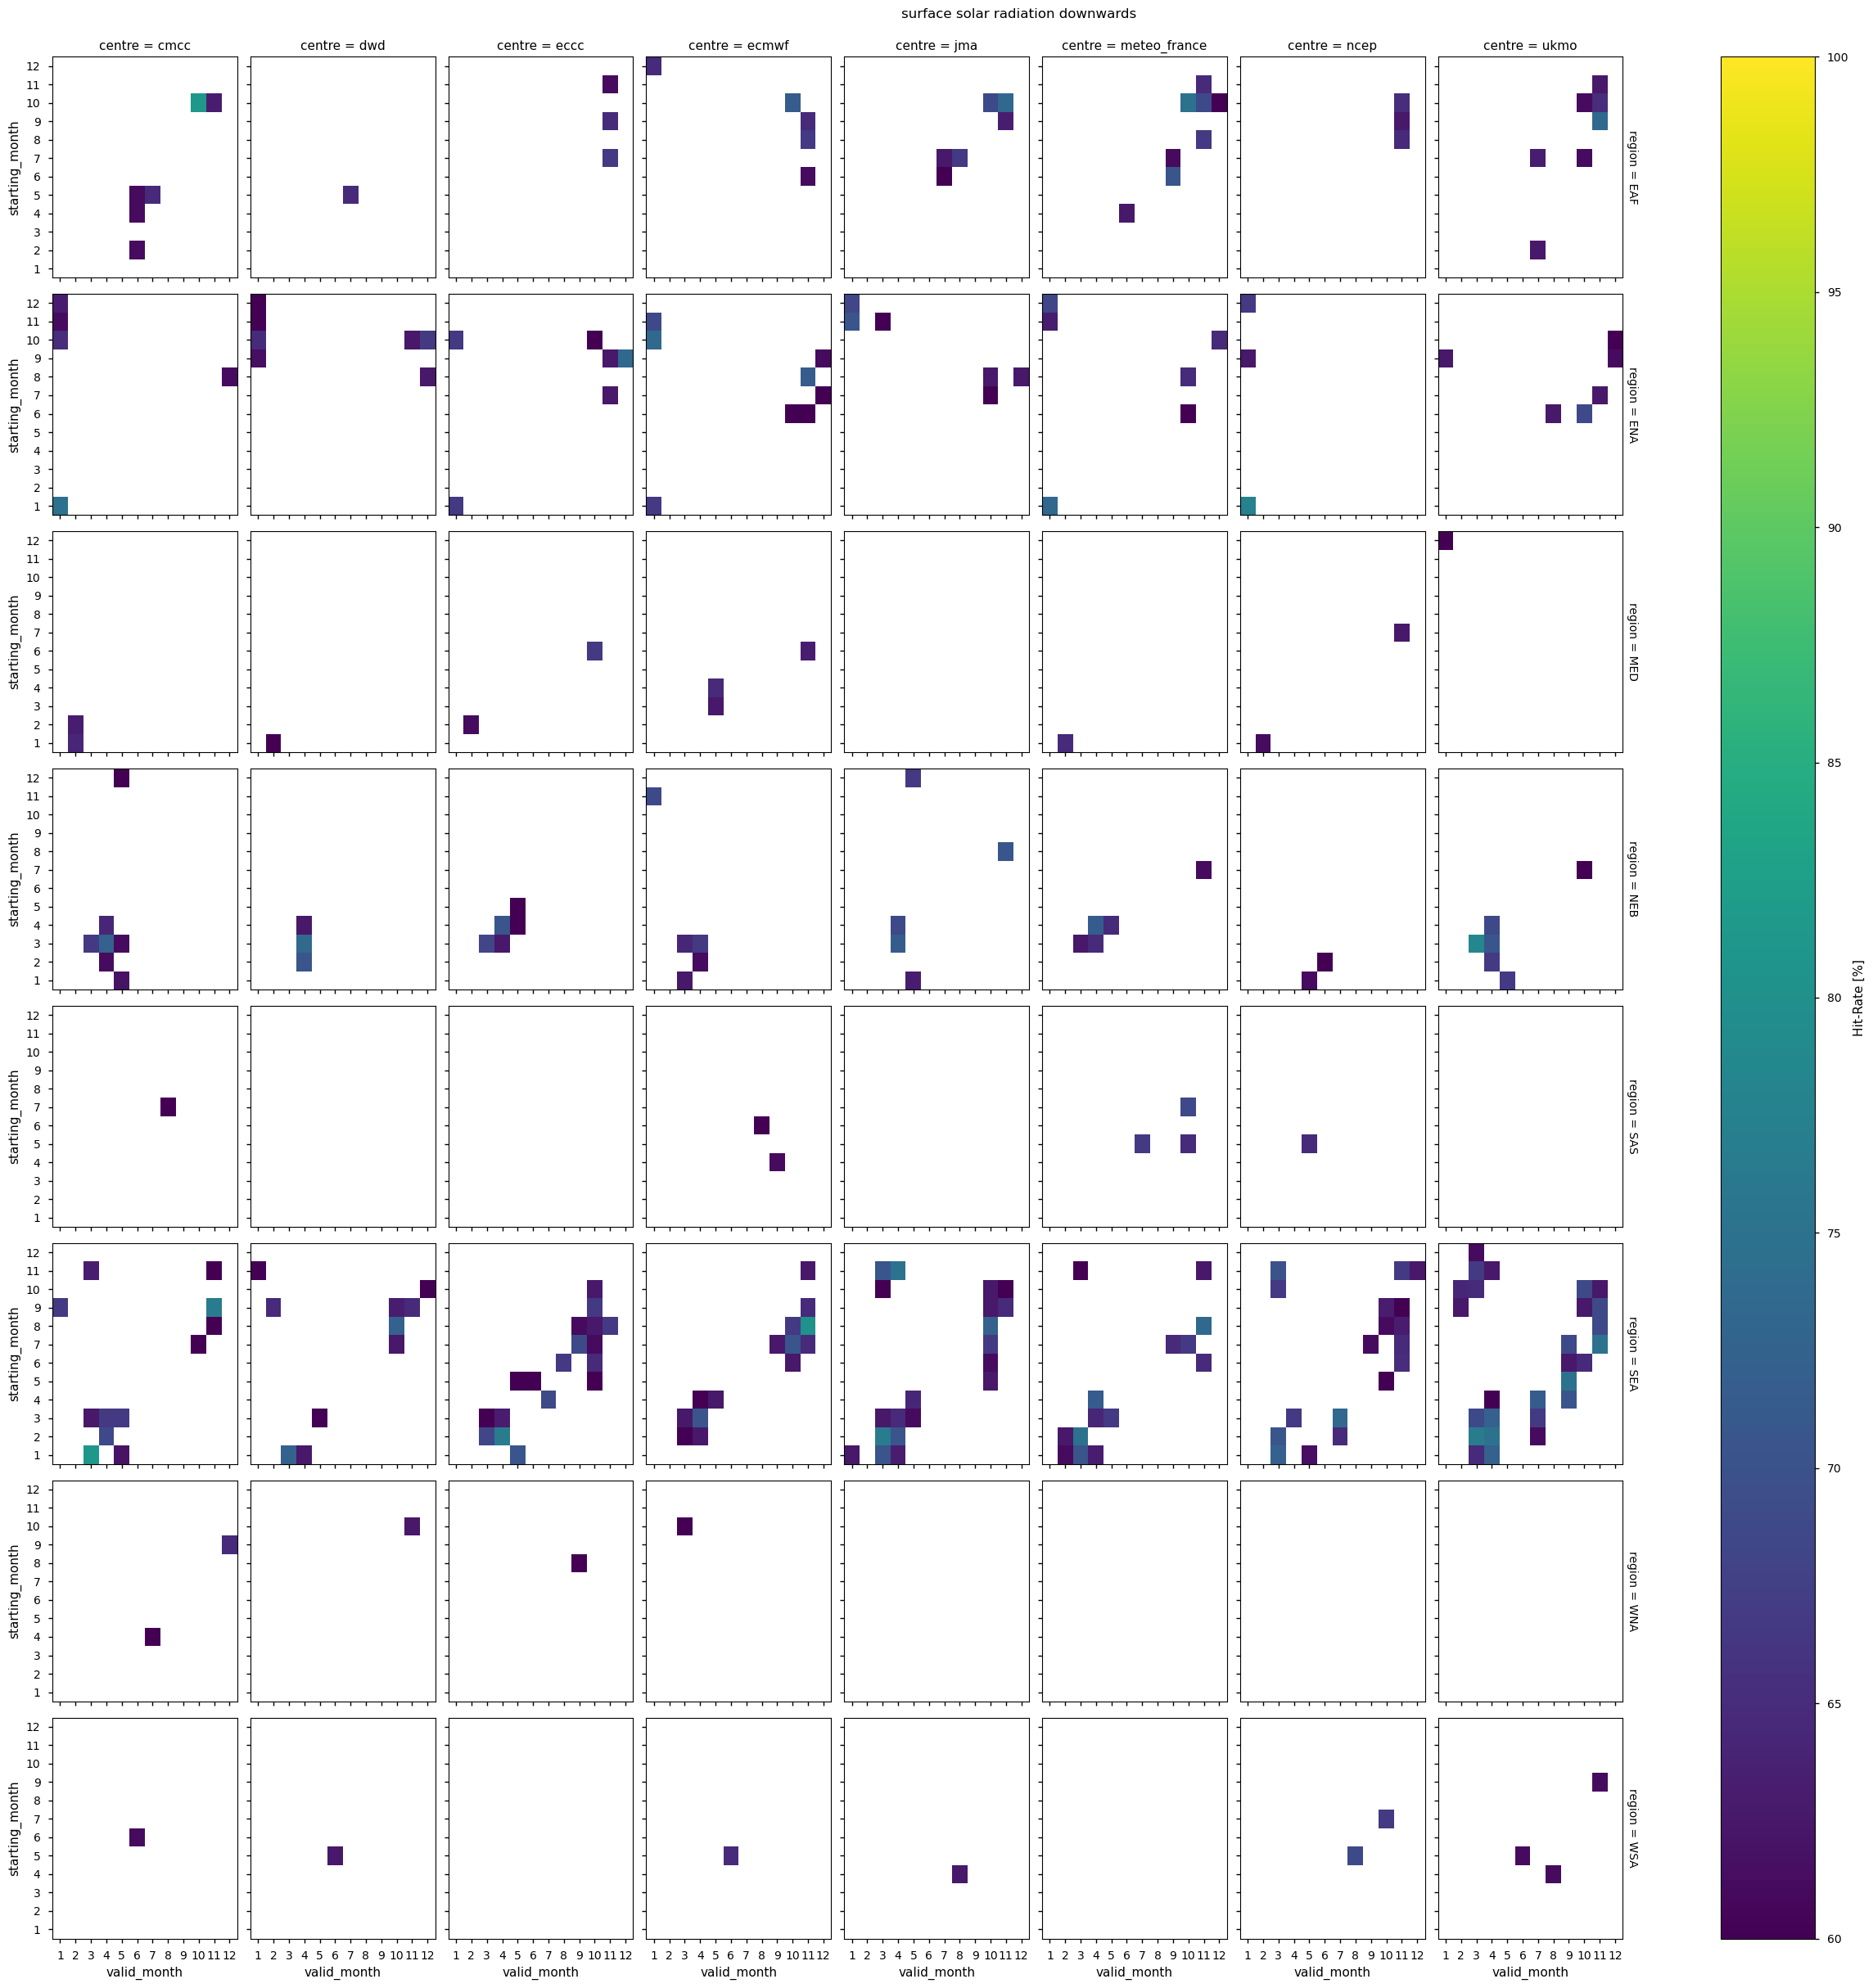

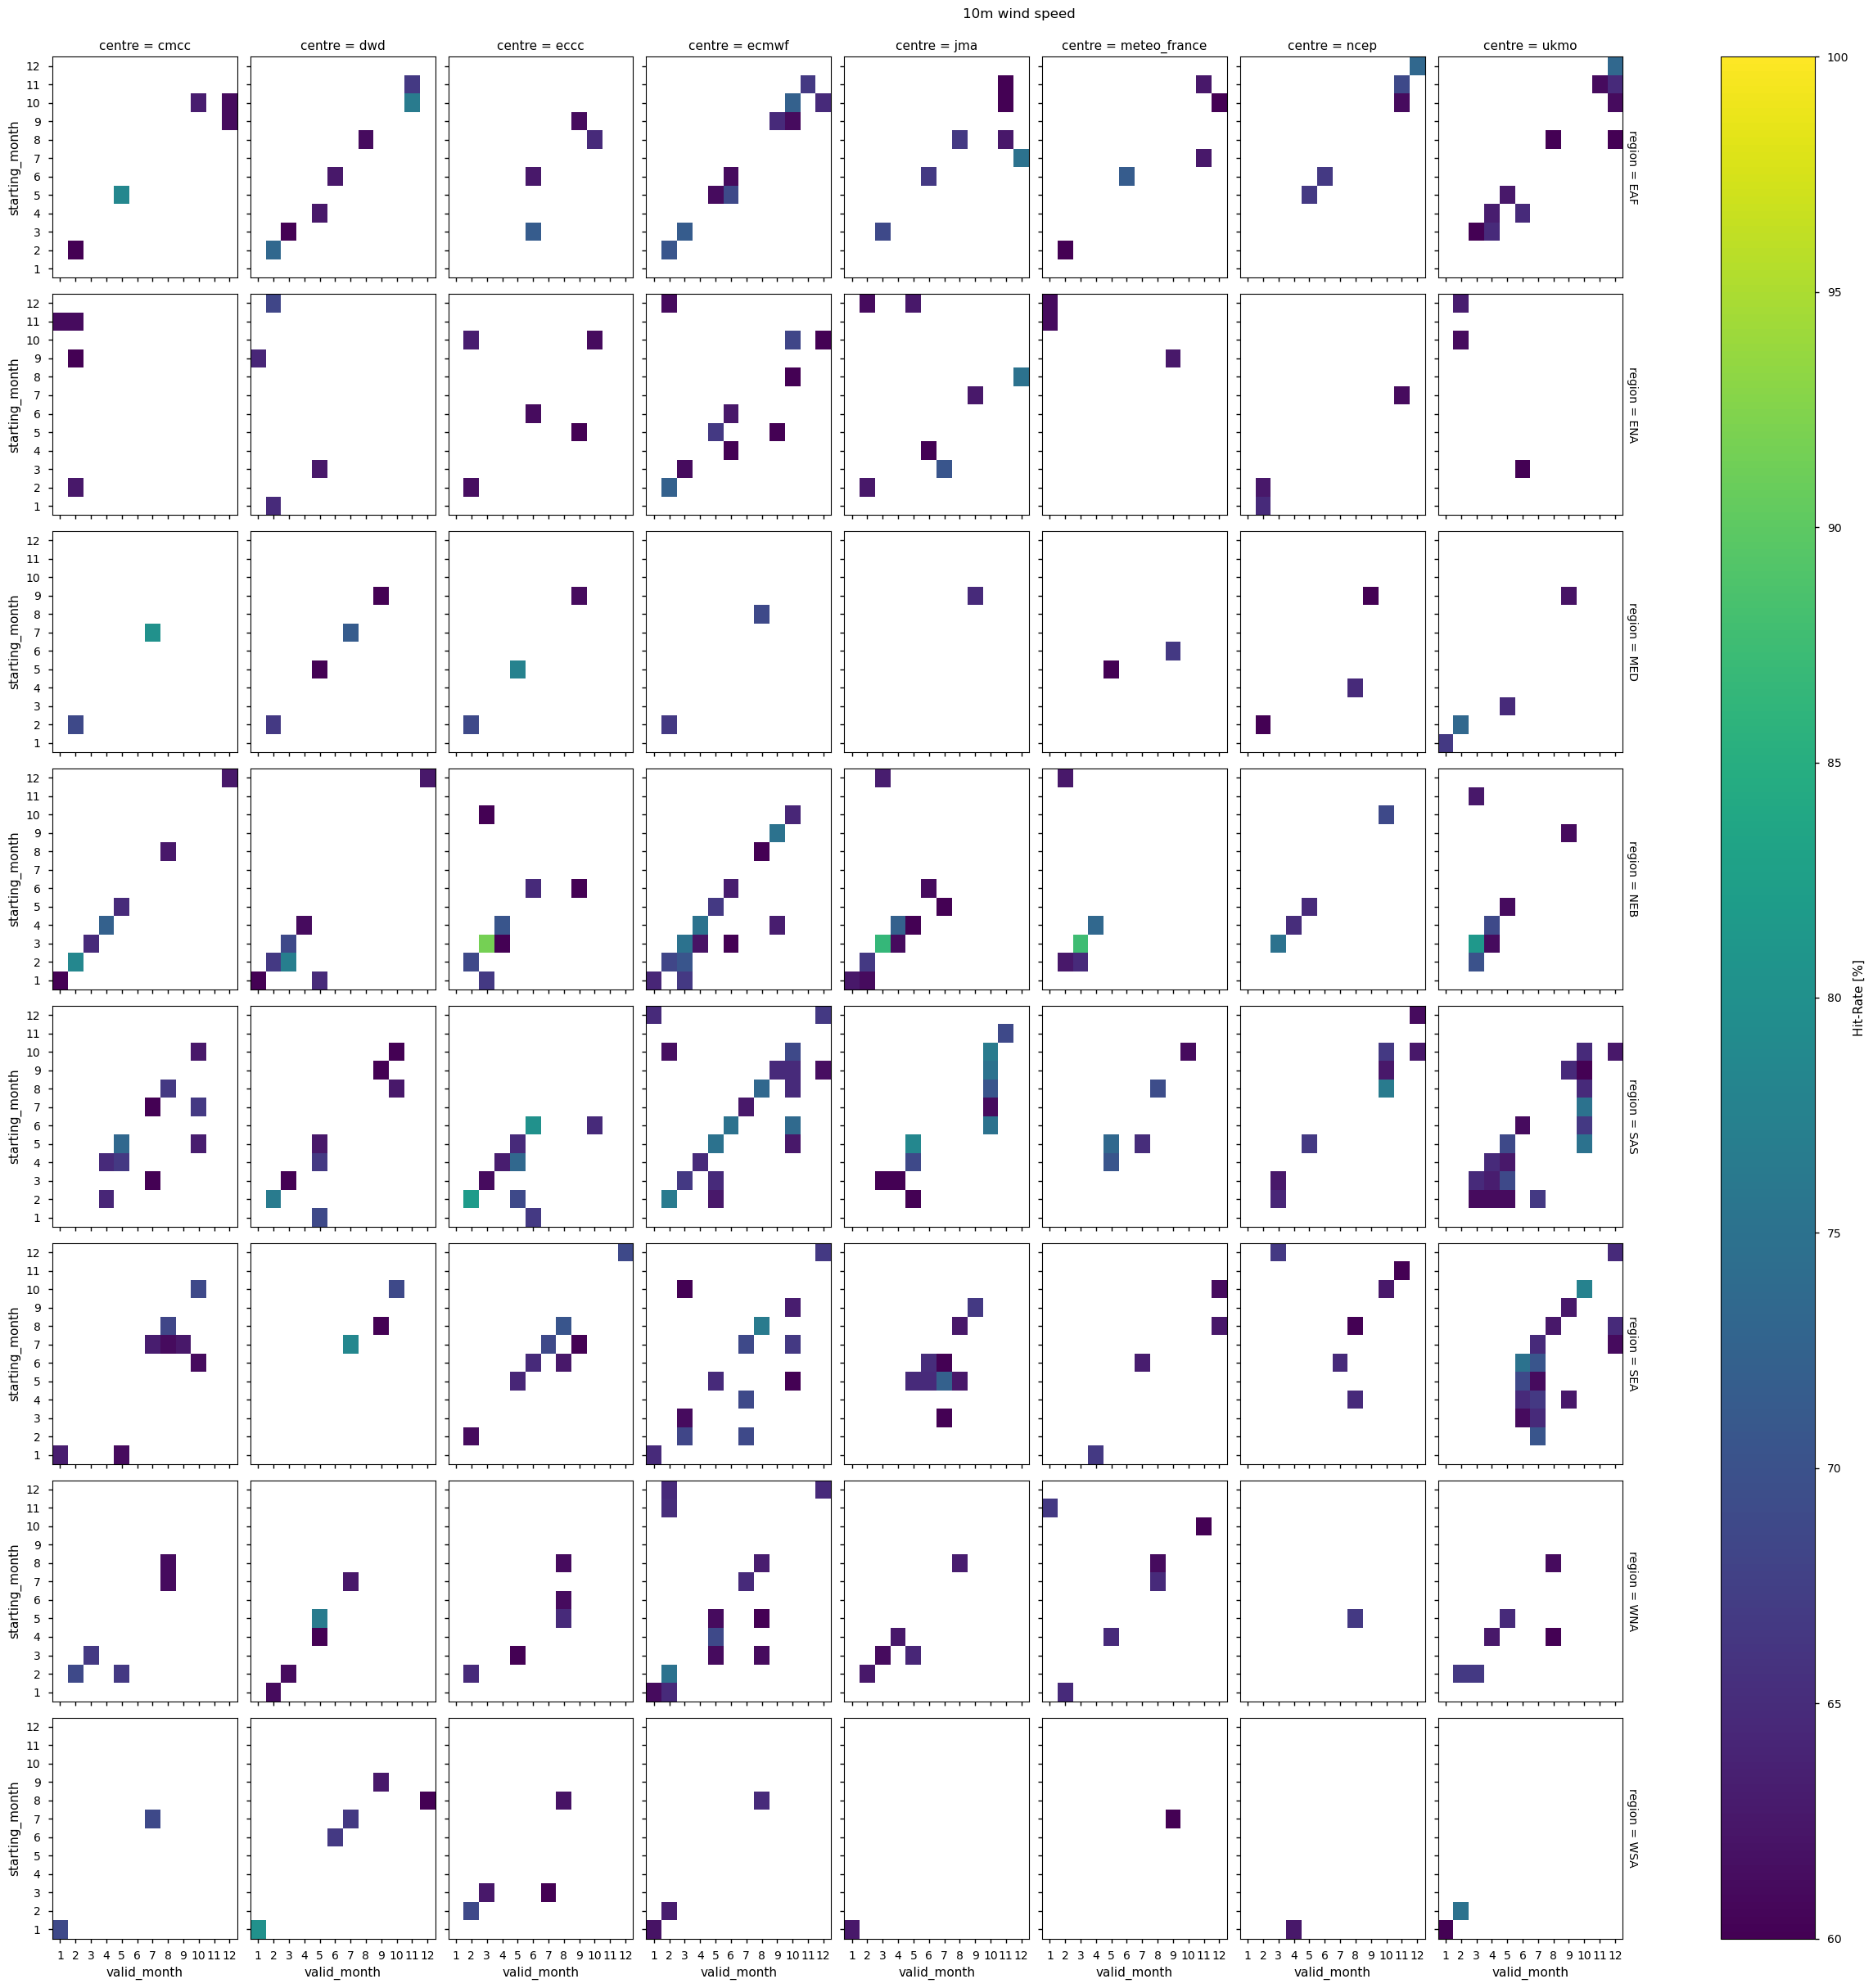

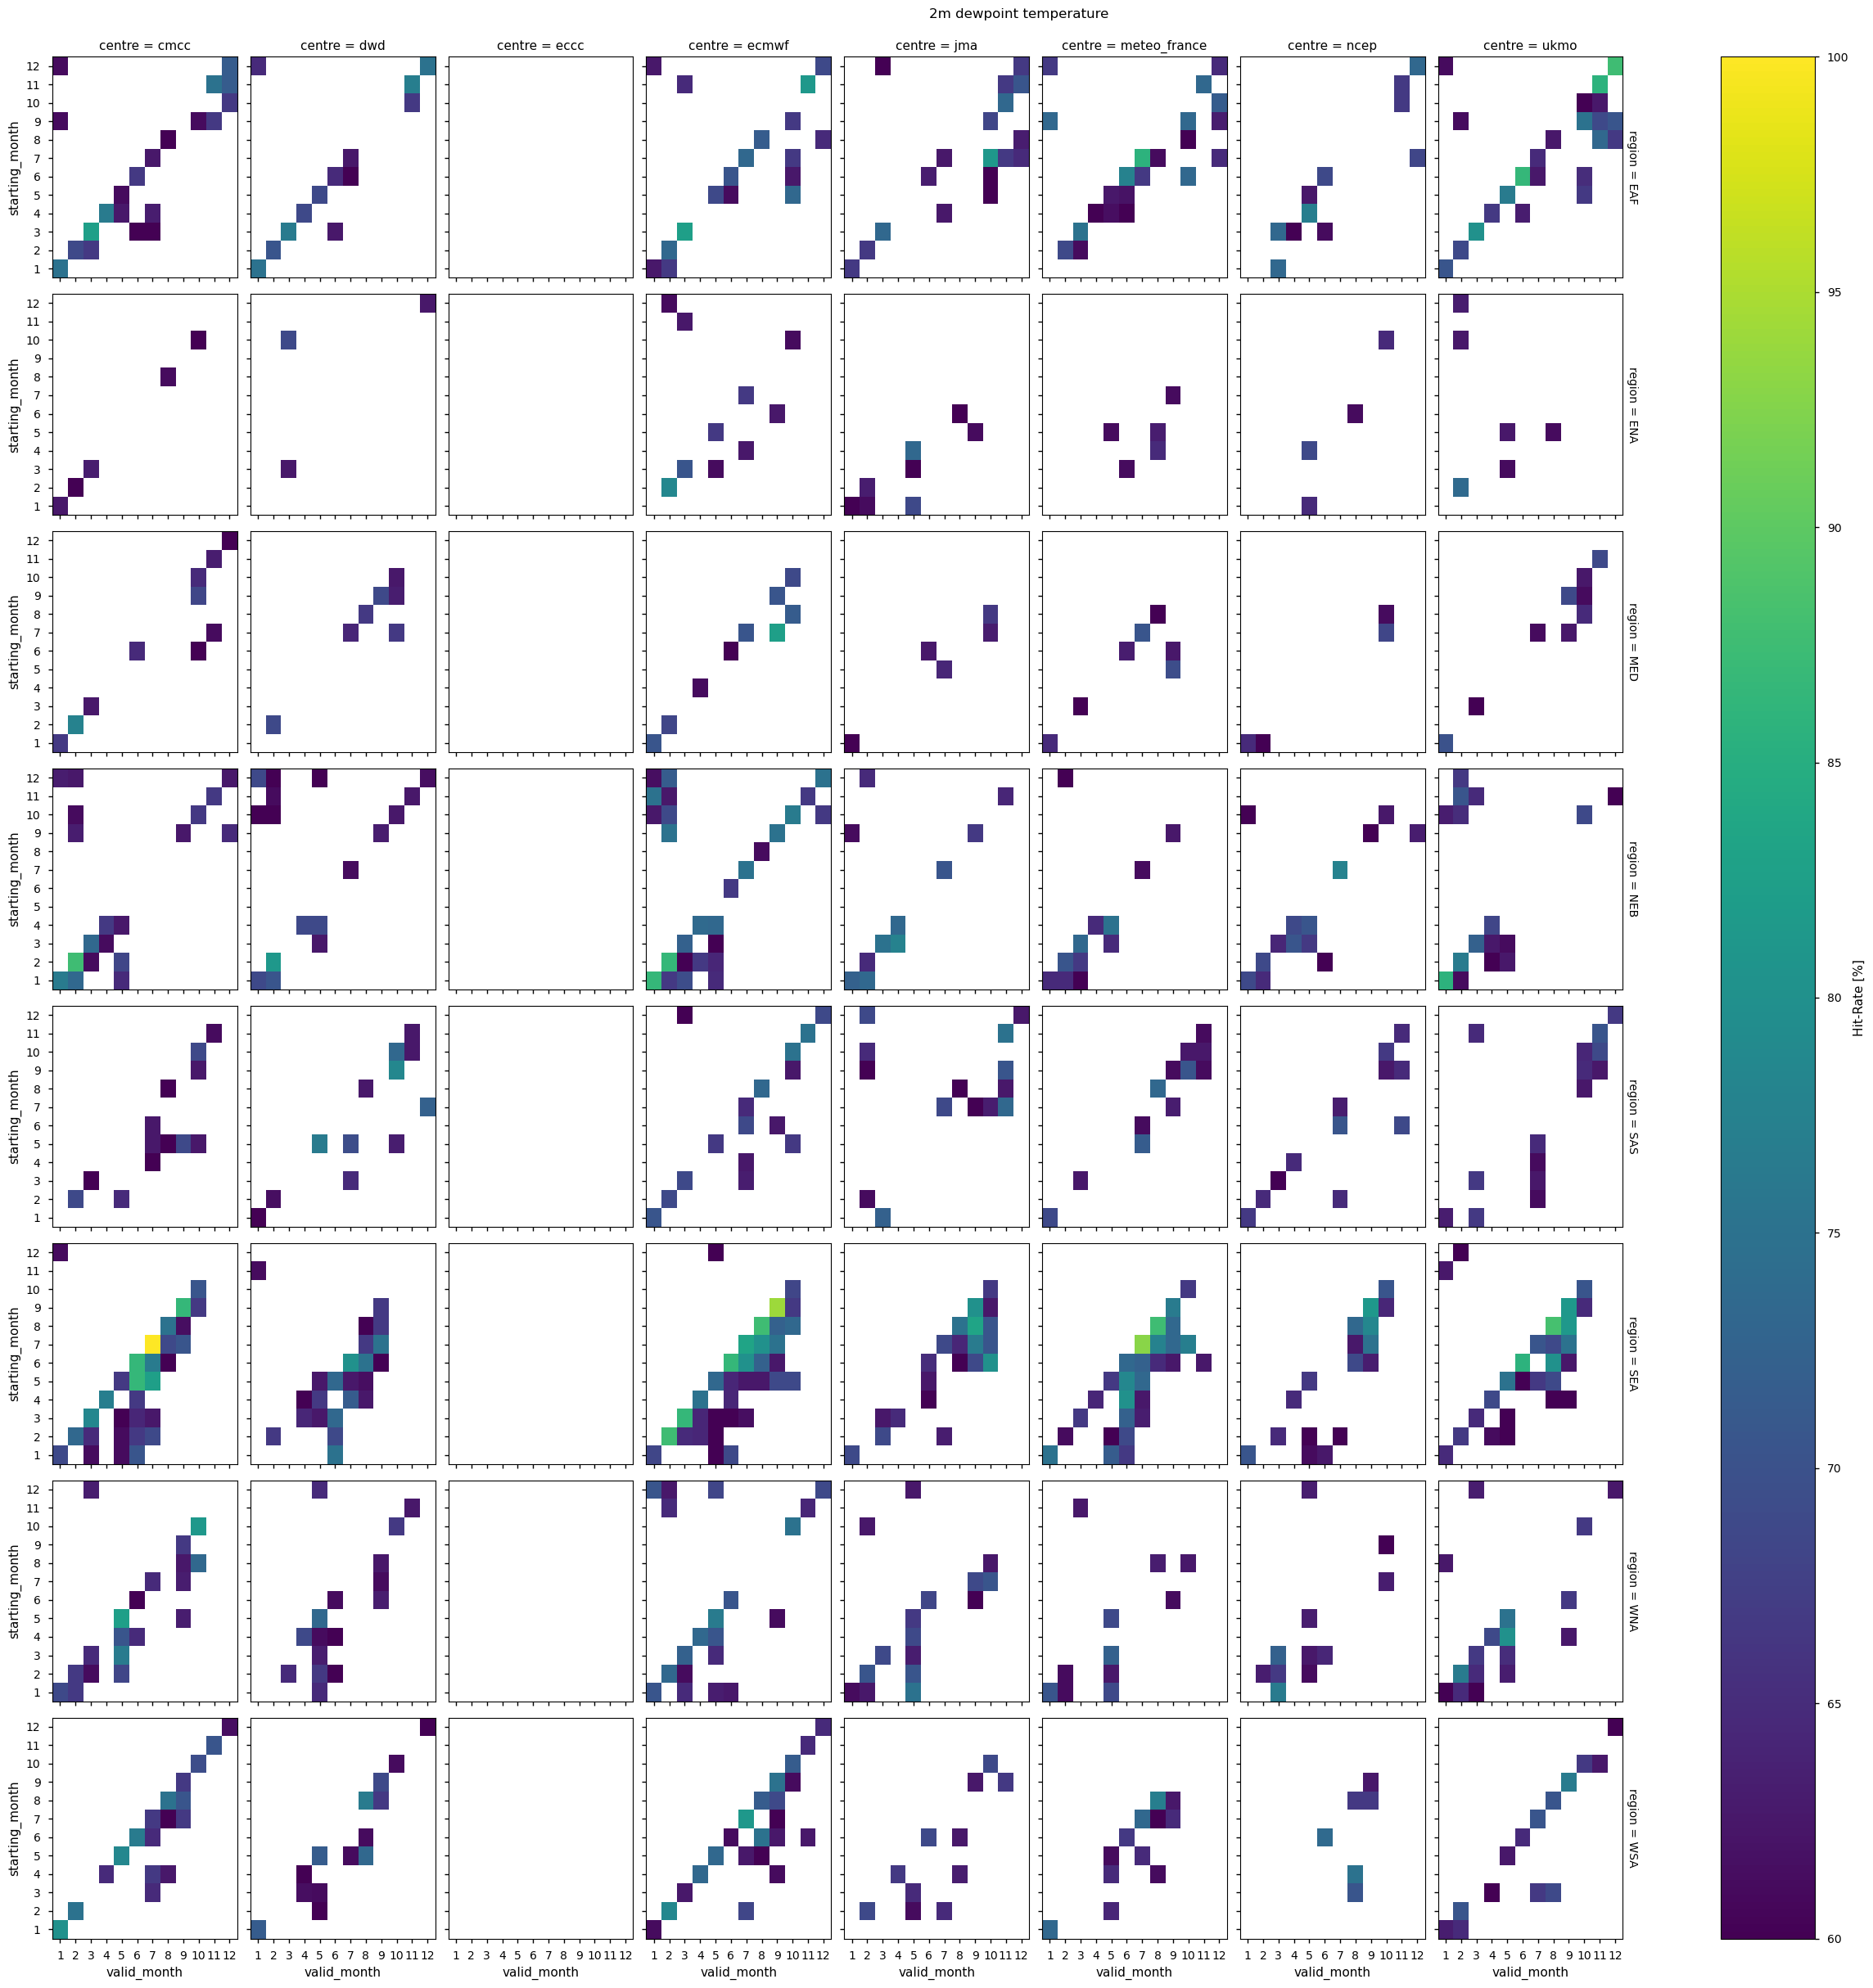

In [27]:
for var, da in hit_rate_mask.data_vars.items():
    da.attrs = {"long_name": "Hit-Rate", "units": "%"}
    facet = da.plot(
        col="centre",
        row="region",
        x="valid_month",
        xticks=range(1, 13),
        yticks=range(1, 13),
        vmin=60,
        vmax=100,
    )
    facet.fig.suptitle(f"{da.name.replace('_', ' ')}", y=1.01)
    plt.show()